In [1]:
import astropy.units as u
import numpy as np
import warnings 
import sys 
warnings.filterwarnings('ignore')
sys.path.append('./../')

from tools_contsub_main import *
from tools_contsub_misc import *
from tools_contsub_units import *
from tools_contsub_plots import *
from tools_contsub_anchoring import * 
from tools_contsub_smoothregrid import * 
from tools_contsub_postprocess import * 

In [2]:
galaxy = 'ngc5194'
galaxy_muse = galaxy
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/%s/' %galaxy
rootdir_bp = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/' 

narrowband_filter = 'f658n'
instrument_f555w  = 'acs'
instrument_f65Xn = 'acs'
instrument_f814w = 'acs'

# Load files
hdu_hst_f555w   = get_hdu(rootdir, 'hst/%s*%s*f555w*.fits' %(galaxy, instrument_f555w))
hdu_hst_f65Xn   = get_hdu(rootdir, 'hst/%s*%s*%s*.fits' %(galaxy, instrument_f65Xn, narrowband_filter))
hdu_hst_f814w   = get_hdu(rootdir, 'hst/%s*%s*f814w*.fits' %(galaxy, instrument_f814w))

# Get filter curve info
bp = get_bandpassinfo(rootdir_bp)

# Cosmic ray thresholds
cr_threshold = 0.25
cr_dilation_iterations = 1

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5194/hst/ngc5194_hlsp_heritage_hst_acs-wfc_m51_f555w_v1_drz_sci.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5194/hst/ngc5194_hlsp_heritage_hst_acs-wfc_m51_f658n_v1_drz_sci.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5194/hst/ngc5194_hlsp_heritage_hst_acs-wfc_m51_f814w_v1_drz_sci.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F550M.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F555W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F658N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F814W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F555W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F657N.dat
/Users/abarnes/Dropbox

[Info] Outputing to the following: /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5194/hst_contsub/
[INFO] Remove NaN values around edge of image...
[INFO] Reprojecting the input image to match the template WCS...
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distort

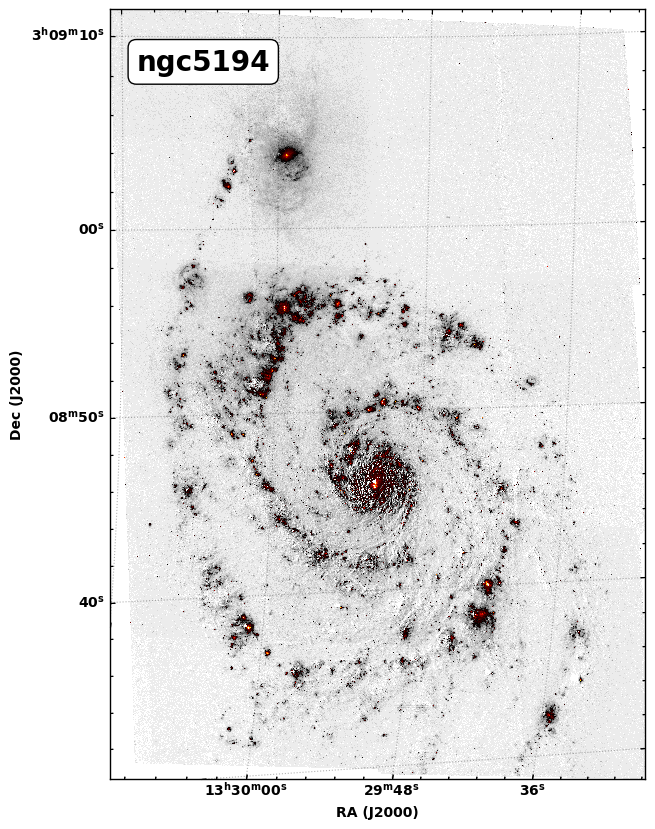

In [3]:
# Make paths
make_paths(rootdir)

# Convert units 
hdu_hst_f555w = get_nanzeros(hdu_hst_f555w)
hdu_hst_f65Xn = get_nanzeros(hdu_hst_f65Xn)
hdu_hst_f814w = get_nanzeros(hdu_hst_f814w)

hdu_hst_f65Xn = remove_nan_padding(hdu_hst_f65Xn)
hdu_hst_f555w = get_regrid(hdu_hst_f555w, hdu_hst_f65Xn)
hdu_hst_f814w = get_regrid(hdu_hst_f814w, hdu_hst_f65Xn)

hdu_hst_f555w, hdu_hst_f65Xn, hdu_hst_f814w = get_covmask(hdu_hst_f555w, hdu_hst_f65Xn, hdu_hst_f814w)

hdu_hst_f555w = get_electrons_2_ergcm2sA(hdu_hst_f555w)
hdu_hst_f65Xn = get_electrons_2_ergcm2sA(hdu_hst_f65Xn)
hdu_hst_f814w = get_electrons_2_ergcm2sA(hdu_hst_f814w)

# Continuum subtract       
hdu_hst_halpha, hdu_hst_cont = get_contsub(hdu_hst_f65Xn.copy(), 
                                hdu_hst_f555w.copy(), 
                                hdu_hst_f814w.copy(), 
                                bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'], 
                                bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'], 
                                bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])

# Convert units
photbw = bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth']
hdu_hst_halpha = get_ergcm2sA_2_ergcm2s(hdu_hst_halpha, photbw)
hdu_hst_cont = get_ergcm2sA_2_ergcm2s(hdu_hst_cont, photbw)

# Make maps plots
make_plots_map(hdu_hst_halpha, galaxy, 'hst_%s_contsub' %narrowband_filter, rootdir)

# Save files
write_hdu(hdu_hst_halpha, rootdir, '%s_hst_%s_contsub.fits' %(galaxy, narrowband_filter))
write_hdu(hdu_hst_cont, rootdir, '%s_hst_%s_cont.fits' %(galaxy, narrowband_filter))

In [4]:
# # Coverage mask
# hdu_mask = get_mask(hdu_hst_halpha)

# # Interpolate negatives
# hdu_hst_halpha_i = get_interp_negs(hdu_hst_halpha, hdu_mask)

# # Remove cosmic rays
# hdu_hst_halpha_ic = get_cosmicrays(hdu_hst_halpha_i, hdu_mask, threshold=cr_threshold, dilation_iterations=cr_dilation_iterations)

# # Save files
# write_hdu(hdu_hst_halpha_i, rootdir, '%s_hst_%s_contsub_i.fits' %(galaxy, narrowband_filter))
# write_hdu(hdu_hst_halpha_ic, rootdir, '%s_hst_%s_contsub_ic.fits' %(galaxy, narrowband_filter))